In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nilearn import image 
from nilearn.plotting import view_img, glass_brain, plot_stat_map

In [2]:
data_dir = "C:/Users/Asus/Desktop/fmri/bold/"
image_name = "sub-0025_task-gstroop_acq-seq_space-MNI152NLin2009cAsym_desc-preproc_bold.nii"
image_path = os.path.join(data_dir, image_name)
image_4d = image.load_img(image_path)

In [3]:
print(image_4d.shape)
n_tr = image_4d.shape[3] #this extracts the time points in the data
tr = 2.0 #is set according to value found in the amsterdam dataset overview

(65, 77, 60, 245)


In [4]:
#load in mask received from fsleyes based on one of our brains
#should work for all of them since they are aligned to the same template
mask_dir = "C:/Users/Asus/Desktop/fmri/"
amygdala_left = "harvardoxford-subcortical_prob_Left_Amygdala.nii"
amygdala_left_path = mask_dir+amygdala_left
amygdala_left_img = image.load_img(amygdala_left_path)
amygdala_right = "harvardoxford-subcortical_prob_Right_Amygdala.nii"
amygdala_right_path = mask_dir+amygdala_right
amygdala_right_img = image.load_img(amygdala_right_path)

In [26]:
# Get the mask data
import nibabel as nib
amygdala_left_data = amygdala_left_img.get_fdata()
amygdala_right_data = amygdala_right_img.get_fdata()
# Combine the left and right amygdala masks using logical OR
mask_data = np.logical_or(amygdala_left_data, amygdala_right_data)

# Apply a threshold to create a binary mask
threshold_value = 0.0  # Adjust this value based on your mask data
binary_mask_data = (mask_data > threshold_value).astype(np.int)

# Create a new NIfTI image for the binary mask
binary_mask_img = nib.Nifti1Image(binary_mask_data, affine=amygdala_right_img.affine)

# Resample the binary mask to match the fMRI image
resampled_mask_img = image.resample_to_img(binary_mask_img, image_4d, interpolation='nearest')


C:\Users\Asus\AppData\Local\Temp\ipykernel_22696\2109091245.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_mask_data = (mask_data > threshold_value).astype(np.int)


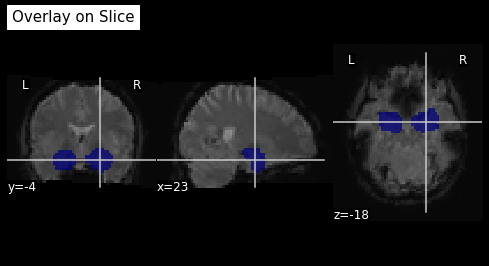

In [27]:
#Plot the mask on a slice of the brain to see if everything is correct
from nilearn.image import index_img
from nilearn.plotting import plot_roi

# Select the tenth volume from the 4D image as the background image
brain_slice = index_img(image_4d, index=10)

# Plot the single slice on top of the full brain image
plot_roi(resampled_mask_img, bg_img=brain_slice, title='Overlay on Slice')

In [11]:
from nilearn import image, masking
import nibabel as nib
import numpy as np
masked_data = masking.apply_mask(image_4d, resampled_mask_img)

In [12]:
print(masked_data.shape)

(245, 1055)


In [36]:
# Conducting the spatial smoothing on the fMRI images
# Is this necessayr? Is brain not smoothed already?
data_image = Brain_Data(image_4d)

fwhm=8 #parameter defining extend of smoothing
#the width of the Gaussian kernel at half of its maximum height (larger FWHM means more extensive smoothing)
data_image_smth = data_image.smooth(fwhm=fwhm) # the image after smoothing with a gaussian kernel

C:\Users\Asus\anaconda3\envs\modelling\lib\site-packages\nilearn\maskers\nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


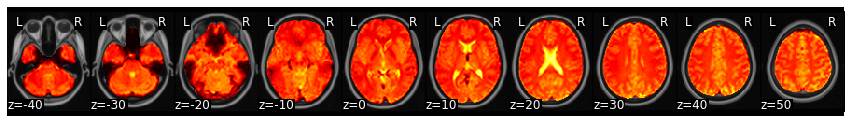

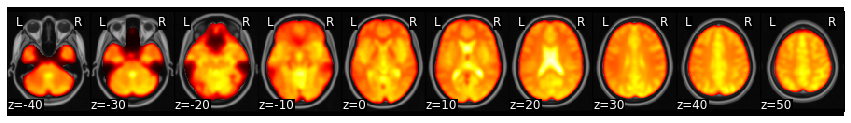

In [6]:
data_image.mean().plot()
data_image_smth.mean().plot()

In [86]:
smooth_dir = "C:/Users/Asus/Desktop/fmri/smooth/"
image_smth_name = 'smth8' + image_name
data_image_smth.write(os.path.join(smooth_dir, image_smth_name))

In [38]:
event_dir = "C:/Users/Asus/Desktop/fmri/events/"
event_file_name = "sub-0025_task-gstroop_acq-seq_events.tsv" #this should be made nicer with formatting of the participant number
event_file_path = os.path.join(event_dir, event_file_name)
event_file_df  = pd.read_csv(event_file_path, sep="\t") #read event file into dataframe
display(event_file_df)

,onset,duration,trial_type,img_gender,word_gender,response_time,response_hand,response_accuracy
0,1.0228,0.5,incongruent,male,female,1.0411,left,correct
1,6.0394,0.5,incongruent,male,female,0.3254,right,incorrect
2,11.5560,0.5,incongruent,female,male,0.4757,right,correct
3,16.5726,0.5,incongruent,female,male,0.5590,right,correct
4,21.0892,0.5,congruent,female,female,0.4853,right,correct
...,...,...,...,...,...,...,...,...
91,456.0330,0.5,incongruent,female,male,0.5776,right,correct
92,461.0496,0.5,congruent,female,female,0.5899,right,correct
93,465.5662,0.5,congruent,female,female,0.5571,right,correct
94,470.0828,0.5,congruent,male,male,0.6605,left,correct


In [39]:
events = (event_file_df
          .query('response_accuracy == "correct"') #filter out incorrect trials
          .loc[:,['onset', 'trial_type']] #selet columns
          .rename(columns={"onset": "Onset", "trial_type": "Stim"}) #rename
          )

In [40]:
design_mat = onsets_to_dm(events, sampling_freq=1/tr, run_length=n_tr) #converts the df to a design matrix
#he event onsets are binned into time bins based on the sampling frequency. Each bin corresponds to a time point in the design matrix.
#For each time bin, the design matrix indicates whether an event of interest occurred at that time point. 
#Each column in the design matrix typically represents a different condition or regressor.
#Attention here! this is influenced by the TR
design_mat.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   incongruent  245 non-null    float64
 1   congruent    245 non-null    float64
dtypes: float64(2)
memory usage: 4.0 KB


C:\Users\Asus\anaconda3\envs\modelling\lib\site-packages\nltools\file_reader.py:79: UserWarning: Only 2 columns in file, assuming all stimuli are the same duration
  warnings.warn(


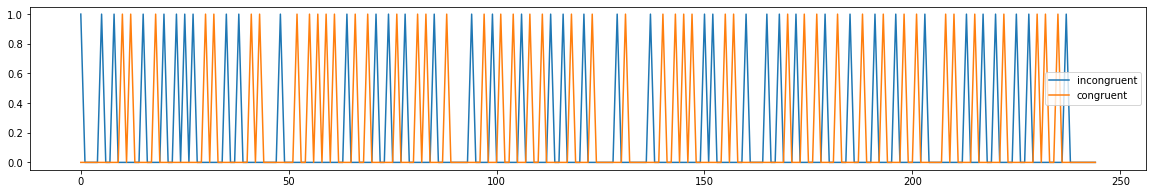

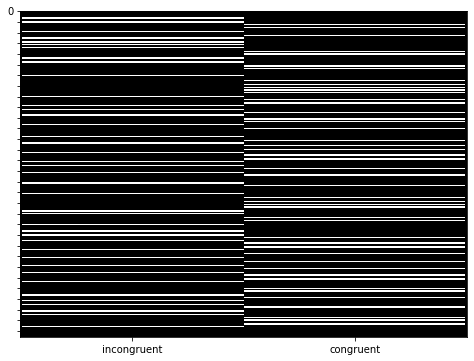

In [41]:
#some visualization of the design matrix here
f,a = plt.subplots(figsize=(20,3))
design_mat.plot(ax=a) # show the onset of two conditions together across the scans
design_mat.heatmap()  # show the onset of two conditions separately side by side

In [42]:
design_mat_conv = design_mat.convolve() #convolution with HRF function

<Axes: >

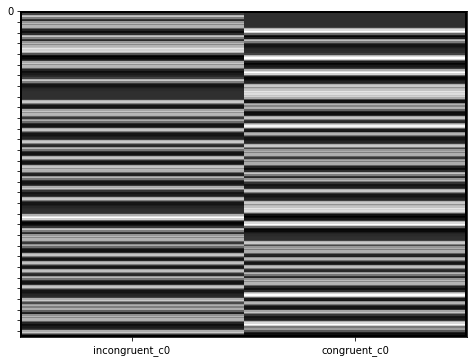

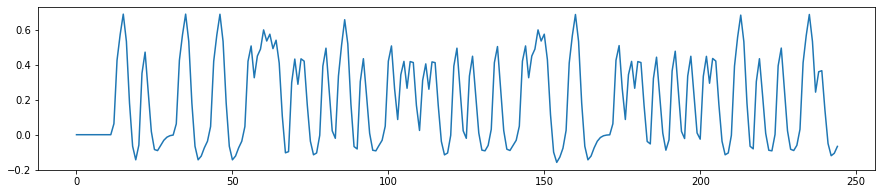

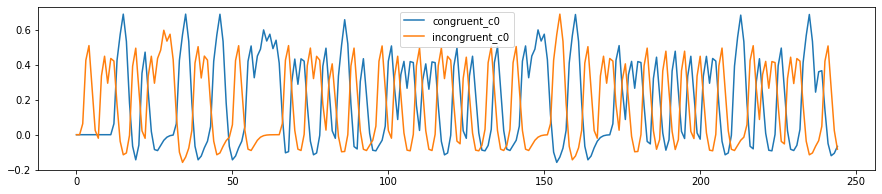

In [43]:
# Let's visualize the convolution result
design_mat_conv.heatmap() # Convolved onsets separately for each condition

f,a = plt.subplots(figsize=(15,3))
design_mat_conv['congruent_c0'].plot(ax=a) # Convolved onsets only for congruent condition
#after convolution the conditions receive the ending c0

f,a = plt.subplots(figsize=(15,3))
design_mat_conv[['congruent_c0','incongruent_c0']].plot(ax=a) # Convolved onsets for both congruent and incongruent condition

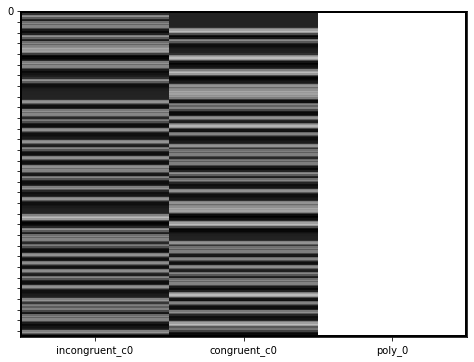

In [44]:
# Add intercept regressor
design_mat_conv_poly = design_mat_conv.add_poly()
design_mat_conv_poly.heatmap()

In [45]:
data_image_smth.X = design_mat_conv_poly
results_flm = data_image_smth.regress()

In [46]:
# Print the shapes of the design matrix and fMRI data
print("Shape of design matrix (design_mat_conv_poly):", design_mat_conv_poly.shape)
print("Shape of fMRI data (data_image_smth.data):", data_image_smth.data.shape)

Shape of design matrix (design_mat_conv_poly): (245, 3)
Shape of fMRI data (data_image_smth.data): (245, 238955)


In [47]:
# Let's check out the structure of the modeling result
print(results_flm.keys()) # the estimates for all the predictors
print(data_image_smth.X.columns) # all the predictors included in the model, you should be able to recognize them

dict_keys(['beta', 't', 'p', 'df', 'sigma', 'residual'])
Index(['incongruent_c0', 'congruent_c0', 'poly_0'], dtype='object')


In [48]:
# first we need to see which predictors we want to contrast
print(data_image_smth.X.columns)

# defining the contrast
c1 = np.zeros(len(results_flm['beta']))
c1[[0]] = -1
c1[[1]] = 1
print(c1)

Index(['incongruent_c0', 'congruent_c0', 'poly_0'], dtype='object')
[-1.  1.  0.]


In [56]:
# applying the contrast and plot the result
control = results_flm['beta'] * c1
print(control.shape)


<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(238955,), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)>


In [ ]:
#control.iplot()

In [87]:
# Reshape the mask data array to a 1D array
mask_1d = mask_data.ravel()

# Get the indices where mask values are 1 (inside the mask)
mask_indices = np.where(mask_1d == 1)[0]

print(mask_indices)

[ 94877  94878  94879 ... 210559 210618 210619]


In [88]:
control_data = control.data

In [89]:
print(control_data)

[ 3.62047044  3.68484668 -2.4474719  ...  3.39171958 -5.91074977
  0.91911572]


In [90]:
amygdala_contrast_values = control_data[mask_indices]
print(amygdala_contrast_values)

[ -4.6052715  -16.13872167 -30.04171376 ...  11.21699226 -28.16670258
 -15.85559698]


In [91]:
np.mean(amygdala_contrast_values)

-6.379894346767616

In [85]:
# Convert the array to a pandas DataFrame
df = pd.DataFrame(amygdala_contrast_values, columns=['Contrast_Values'])

# Save the DataFrame to a CSV file
contrasts_amygdala_file = "amygdala_contrast_values.csv"
contrasts_amygdala_dir = "C:/Users/Asus/Desktop/fmri/contrasts/"
contrasts_amygdala_path = contrasts_amygdala_dir + contrasts_amygdala_file
df.to_csv(contrasts_amygdala_path, index=False)